In [30]:
import pandas as pd
import pprint
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("april_2023.csv", dtype={'license': object}) # ASSUMES YOU HAVE CSV file in directory
df2 = pd.read_csv("feb_2024.csv") # ''   '' 

threshold = 30  
columns_to_drop_df= ["id", "listing_url", "scrape_id", "host_id", "host_url", "picture_url", "host_thumbnail_url", "host_picture_url",
                     "name", "description", "neighborhood_overview", "host_about","last_scraped", "host_since", "calendar_last_scraped", 
                     "first_review", "last_review", "host_verifications", "amenities", "host_name"] # Do not make sense for PCA


# april_2023 dataset
for i in range(df.shape[1]):
    percent_nans = df.iloc[:, i].isnull().mean() * 100
    if percent_nans > threshold:
        columns_to_drop_df.append(df.columns[i])


# feb_2024 dataset:
for i in range(df2.shape[1]):
    percent_nans = df2.iloc[:, i].isnull().mean() * 100
    if percent_nans > threshold and df2.columns[i] not in columns_to_drop_df:
        columns_to_drop_df.append(df2.columns[i])

columns_to_drop_df = list(dict.fromkeys(columns_to_drop_df)) # rid column of duplicates
df.drop(columns=columns_to_drop_df, inplace=True)
df2.drop(columns=columns_to_drop_df, inplace=True)

cat_vars = []
# impute NaNs
for i, ser in enumerate(df.dtypes):
    if ser == "object":
        cat_vars.append(df.columns[i])
        df.iloc[:, i] = df.iloc[:, i].fillna('Unknown')
        df2.iloc[:, i] = df2.iloc[:, i].fillna('Unknown')
    else: #should be numerical 
        df.iloc[:, i] = df.iloc[:, i].fillna(df.iloc[:, i].median())
        df2.iloc[:, i] = df2.iloc[:, i].fillna(df2.iloc[:, i].median())

print(df.shape[1])
print(df2.shape[0])

46
43241


In [15]:
# Combine the datasets
combined = pd.concat([df, df2], sort=False).reset_index(drop=True)

# One-hot encode
combined_encoded = pd.get_dummies(combined, columns=cat_vars, drop_first=True, prefix=cat_vars)

# Split the datasets back
df_encoded = combined_encoded.iloc[:len(df)]
df2_encoded = combined_encoded.iloc[len(df):]


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [17]:
# Initialize PCA model
pca = PCA(n_components=2)

# Fit and transform the 2023 dataset
pca_2023 = pca.fit_transform(df_encoded)
# Only transform the 2024 dataset using the same PCA model to ensure comparability
pca_2024 = pca.transform(df2_encoded)

# Convert the PCA results back to DataFrame for easier handling
pca_2023_df = pd.DataFrame(data=pca_2023, columns=['PC1', 'PC2'])
pca_2024_df = pd.DataFrame(data=pca_2024, columns=['PC1', 'PC2'])


In [18]:
print("Explained variance ratio for 2023:", pca.explained_variance_ratio_)
print("Explained variance ratio for 2024:", pca.explained_variance_ratio_)


Explained variance ratio for 2023: [0.85620371 0.10190983]
Explained variance ratio for 2024: [0.85620371 0.10190983]


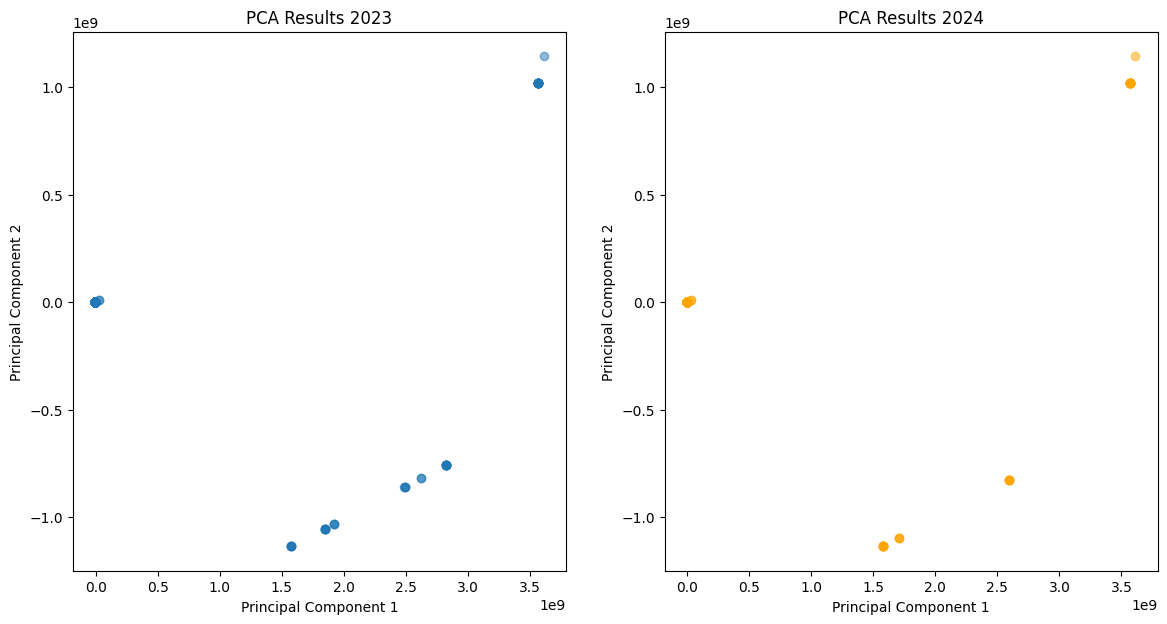

In [19]:
plt.figure(figsize=(14, 7))

# Plot for 2023
plt.subplot(1, 2, 1)
plt.scatter(pca_2023_df['PC1'], pca_2023_df['PC2'], alpha=0.5)
plt.title('PCA Results 2023')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot for 2024
plt.subplot(1, 2, 2)
plt.scatter(pca_2024_df['PC1'], pca_2024_df['PC2'], alpha=0.5, color='orange')
plt.title('PCA Results 2024')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


In [23]:

loadings = pca.components_ # PCA rotational matrix (transforms pca back to original matrix)
feature_names = list(df_encoded.columns)
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)
print(loadings_df['PC1'].abs().sort_values(ascending=False))
print("----------------------------------------------------")
print(loadings_df['PC2'].abs().sort_values(ascending=False))

maximum_maximum_nights               7.332132e-01
maximum_nights_avg_ntm               5.874240e-01
minimum_maximum_nights               3.418532e-01
maximum_nights                       2.162969e-02
host_total_listings_count            3.519042e-08
                                         ...     
host_neighbourhood_Ala Moana         0.000000e+00
host_neighbourhood_Anaheim Resort    0.000000e+00
host_neighbourhood_Arlington Park    0.000000e+00
host_neighbourhood_Attiki            0.000000e+00
host_neighbourhood_Colgate Center    0.000000e+00
Name: PC1, Length: 2289, dtype: float64
----------------------------------------------------
minimum_maximum_nights                  8.274149e-01
maximum_maximum_nights                  5.296832e-01
maximum_nights_avg_ntm                  1.775064e-01
maximum_nights                          5.754824e-02
host_total_listings_count               7.093849e-08
                                            ...     
host_neighbourhood_Five Points South   

In [24]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, random_state=42)
clusters_2023 = kmeans.fit_predict(pca_2023)

# Add the cluster labels to your PCA dataframe
pca_2023_df['cluster'] = clusters_2023


cluster
0    43196
2       29
1       16
Name: count, dtype: int64


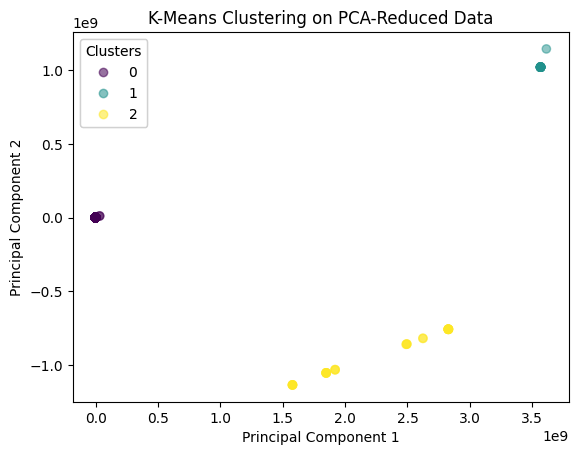

In [28]:
# Check the size of each cluster
print(pca_2023_df['cluster'].value_counts())

# Plot the clustered PCA results
scatter = plt.scatter(pca_2023_df['PC1'], pca_2023_df['PC2'], c=pca_2023_df['cluster'], cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1) 
plt.show()


In [27]:
# Review the centroids of the clusters in the PCA-reduced space
centroids = kmeans.cluster_centers_
print(centroids)



# If you want to interpret the clusters using the original features, 
# you can look at the average values of the original features for each cluster
df_encoded.loc[:,'cluster'] = clusters_2023  # Add the cluster labels to your original encoded dataframe
cluster_means = df_encoded.groupby('cluster').mean()
print(cluster_means)


[[-2.83639124e+06  2.43894199e+05]
 [ 3.57023486e+09  1.02853309e+09]
 [ 2.25506890e+09 -9.30751147e+08]]
         host_listings_count  host_total_listings_count   latitude  longitude  \
cluster                                                                         
0                  114.74831                 173.635638  40.728670 -73.943602   
1                   83.43750                 116.875000  40.765986 -73.976696   
2                   21.37931                  27.896552  40.741420 -73.971399   

         accommodates  bedrooms  minimum_nights  maximum_nights  \
cluster                                                           
0            2.947356  1.375405       18.220553    1.490426e+03   
1            2.875000  1.000000        4.625000    1.342184e+08   
2            2.482759  1.034483        3.000000    6.181724e+02   

         minimum_minimum_nights  maximum_minimum_nights  ...  \
cluster                                                  ...   
0                     18